# Elo Code

In [13]:
from asyncio.windows_events import NULL
import numpy as np
from collections import Counter
from datetime import datetime as dt
import pickle
import bz2
import random
import math
from math import log
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import

In [2]:
with open('C:\\Users\\mmaze\\Desktop\\Capstone\\Elo\\train_and_test_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Sort by date (Final Array)
vball.sort(order='datetime')

In [3]:
# View examples of the data:

# row 0
print(vball[0])
print("")

# Equivalent output to a structured array
print(vball['tournament_name'][1])
print(vball[1]['tournament_name'])

# Calling multiple fields
print(vball[['tournament_name','type']][1])

(80, "25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National', '15U', '21', 'Girls', 'Juniors', 65, 1, 1, 'Home', 1, 'Pool', False, 400, 494, '400.494', 1816, 2144, '1816.2144', True, False, 21, 7, False, 21, 14, 0.75, 21, 33.862354, -118.40166, 'Pacific Standard Time', '2018-07-10T09:00:00.000000')

25th Annual AAU Girls' Junior National Beach Volleyball Championships
25th Annual AAU Girls' Junior National Beach Volleyball Championships
("25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National')


## Functions

In [4]:

# ELO
# https://www.geeksforgeeks.org/elo-rating-algorithm/
import math
from math import log

def KFactor(games_played, k_0_games, k_inf_games, intertia): 
    k_inf_games = k_inf_games - k_0_games
    if k_inf_games <= k_0_games:
        return k_0_games
    else:
        return k_0_games + k_inf_games/(games_played**(1/intertia))

def Probability(rating1, rating2):
    return 1.0 / (1 + (10 ** ((rating2 - rating1) / 400)))

def EloRating(Ra, Rb, K, won):
    # Probability of Player A
    Pa = Probability(Ra, Rb)
    # Case When Player A wins
    if (won) :
        Ra = Ra + K * (1 - Pa)
    # Case When Player A loses
    else :
        Ra = Ra + K * (0 - Pa)
    return(round(Ra, 4))

def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob)) + ((1 - result) * log(1-prob)))


In [5]:
# Example Outputs:
print(Probability(1400, 1700))
print(Probability(1700, 1400))
print(EloRating(Ra=1100, Rb=1000, K=800, won=True))
print(EloRating(Ra=1100, Rb=1000, K=800, won=False))

0.15097955721132328
0.8490204427886767
1387.948
587.948


In [6]:
def Simulator(k_0_games, k_inf_games, intertia, avg_team_rtg, decay_amt="none", restore_amt="none", inital_elo = 1200):
    # elo_db:
    # a dictionary with player id as the key
    # the value is a list of [elo, games_played]
    elo_db = dict()
    # (in)corr_sample_dict:
    # key is list of [games_played, opp_game_played]
    # the value is simply a counter for its respective dictionary
    correct_sample_dict = dict()
    incorr_sample_dict = dict()
    # prob_v_res:
    # This list will be filled with a lists representing each row
    # The first item in this sub list represents a win (1) or loss (0)
    # The following two items hold the Elos
    loop = 0
    test_loop=0
    prob_v_res = []
    max_games_played = 0
    max_opp_game_played = 0
    total_log_loss = 0
    loss_counter = 0
    last_dt = str(vball[0][-1])[0:10]

    for index, match in enumerate(vball):
        if isinstance(decay_amt, float) | isinstance(restore_amt, float):
            # find date. Select [0:10] bc we only want the date not time
            current_dt = str(match[-1])[0:10]
            # if it is a new day then:
            if last_dt != current_dt:
                last_dt = current_dt
                for key, [elo, samp] in elo_db.items():
                    if isinstance(decay_amt, float):
                        if elo > inital_elo:
                            elo_db.update({key: [elo*decay_amt, samp]})
                    elif isinstance(restore_amt, float):
                        if elo < inital_elo:
                            elo_db.update({key: [elo*restore_amt, samp]})

        loop+=1
        # add players to database if needed:
        for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
            if match[person] not in elo_db.keys():
                elo_db.update({match[person]: [inital_elo, 0]})
        # set parameters     
        avg_oppon = .5 * (elo_db.get(match["opponent1_id"])[0] + elo_db.get(match["opponent2_id"])[0])
        opp_game_played = int(.5 * (elo_db.get(match["opponent1_id"])[1] + elo_db.get(match["opponent1_id"])[1])) + 1
        if avg_team_rtg:
            player_elo = .5 * (elo_db.get(match["player_id"])[0] + elo_db.get(match["teammate_id"])[0])
            games_played = int(.5 * (elo_db.get(match["player_id"])[1] + elo_db.get(match["teammate_id"])[1])) + 1
        else:
            player_elo = elo_db.get(match["player_id"])[0]
            games_played = elo_db.get(match["player_id"])[1] + 1

        if games_played > max_games_played:
            max_games_played = games_played
        if opp_game_played > max_opp_game_played:
            max_opp_game_played = opp_game_played
       
        # we will only record accuracy of games past the 206295th match
        # it will caputre the accuracy of 3/5/22 to 6/20/22 games
        if loop >= 206296:
            test_loop += 1

            # skip over situations where both players are unranked or have same elo
            if player_elo == avg_oppon:
                continue

            # compare preds to actual
            prob = Probability(player_elo, avg_oppon)
            total_log_loss += LogLoss(match["win"], prob)
            loss_counter += 1
            if prob > .5:
                pred_win = True
            else:
                pred_win = False
            if pred_win == match["win"]:
                prob_v_res.append([1, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in correct_sample_dict.keys():
                    correct_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    correct_sample_dict.update({str([games_played, opp_game_played]): correct_sample_dict.get(str([games_played, opp_game_played])) + 1})
            else:
                prob_v_res.append([0, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in incorr_sample_dict.keys():
                    incorr_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    incorr_sample_dict.update({str([games_played, opp_game_played]): incorr_sample_dict.get(str([games_played, opp_game_played])) + 1})
        k = KFactor(games_played, k_0_games, k_inf_games, intertia)

        # perform calculations/updates
        new_elo = EloRating(player_elo, avg_oppon, k, match["win"])
        elo_db.update({match["player_id"]: [new_elo, games_played]})
    log_loss = total_log_loss/(loss_counter)
    accuracy_dict = {"correct_sample_dict":correct_sample_dict, "incorr_sample_dict":incorr_sample_dict}
    #print(1 - test_loop/loop)
    return (accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res)

In [7]:
output = Simulator(
    k_0_games = 800, k_inf_games = 1, intertia = 1, avg_team_rtg = True, decay_amt = .98, restore_amt = 1.07)
accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res = output

In [8]:
prob_list = []
for outcome, play1, play2 in prob_v_res:
    if play1 > play2:
        pred_winner = play1
        pred_loser = play2
    else:
        pred_winner = play2
        pred_loser = play1
    if outcome == 1:
        prob_list.append([outcome, pred_winner, pred_loser])
    else:
        prob_list.append([outcome, pred_loser, pred_winner])
assert(len(prob_v_res) == len(prob_list))

prob_list = [[outcome, pred_winner, pred_loser, Probability(pred_winner, pred_loser)] for outcome, pred_winner, pred_loser in prob_list]
out_array_no_ties=np.array(prob_list)
out_array_no_ties[0:10]

array([[1.00000000e+00, 2.17502995e+03, 1.75623705e+03, 9.17644568e-01],
       [0.00000000e+00, 7.55616800e+02, 9.15261795e+02, 2.85163639e-01],
       [0.00000000e+00, 7.55616800e+02, 7.67627945e+02, 4.82721456e-01],
       [1.00000000e+00, 9.47572750e+02, 7.67627945e+02, 7.38047610e-01],
       [1.00000000e+00, 9.47572750e+02, 4.50729350e+02, 9.45836400e-01],
       [1.00000000e+00, 1.08017160e+03, 4.50729350e+02, 9.74001167e-01],
       [1.00000000e+00, 1.08017160e+03, 4.93998150e+02, 9.66891160e-01],
       [1.00000000e+00, 1.04878115e+03, 4.93998150e+02, 9.60592255e-01],
       [1.00000000e+00, 1.04878115e+03, 4.46201150e+02, 9.69784807e-01],
       [1.00000000e+00, 1.27505273e+03, 1.20000000e+03, 6.06360273e-01]])

In [18]:
bins = np.arange(0, 3000, 100)
bins_lt = [[x, x + 100] for x in bins]
bins_wt=bins_lt.copy()
bins_wt.reverse()

In [19]:
#out_array_no_ties contain: Binary Outcome, WT rating, LT rating, and % chance of winning

game_count_array=np.zeros((len(bins_wt),len(bins_lt)))
exp_win_prob_array=np.zeros((len(bins_wt),len(bins_lt)))
actual_win_prob=np.zeros((len(bins_wt),len(bins_lt)))


#Capture game count in each bin (after training)
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                game_count_array[ix,iy]+=1

#Capture expected win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                exp_win_prob_array[ix,iy]+=i[3]/game_count_array[ix,iy]

#Capture actual win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1] and i[0]==1:
                actual_win_prob[ix,iy]+=i[0]/game_count_array[ix,iy]

#Capture residual of actual - expected win probability
residual_win_prob=actual_win_prob-exp_win_prob_array

In [20]:
revised_bins_lt = []
for idx, item in enumerate(bins_lt):
    if idx%2 == 0:
        revised_bins_lt.append(item)
    else:
        revised_bins_lt.append("")
revised_bins_wt = []
for idx, item in enumerate(bins_wt):
    if idx%2 == 0:
        revised_bins_wt.append(item)
    else:
        revised_bins_wt.append("")
    

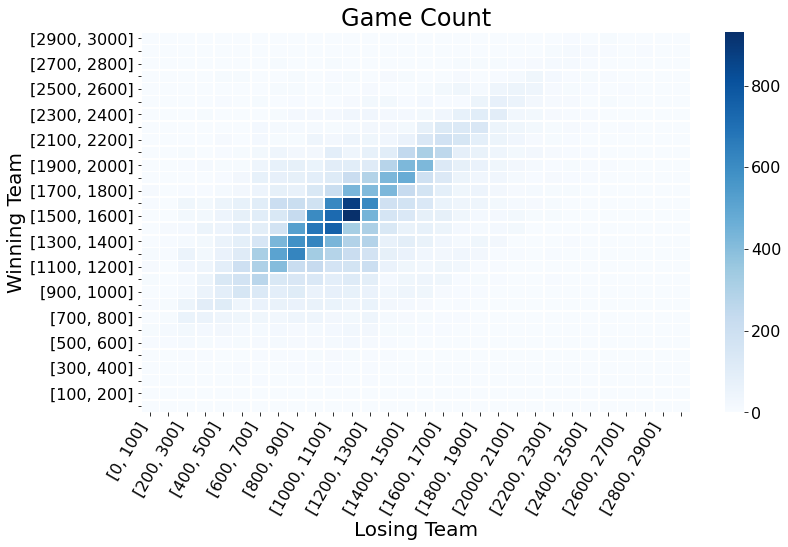

In [21]:
#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)

plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)  
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.xticks(ha='right')
plt.title("Game Count")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

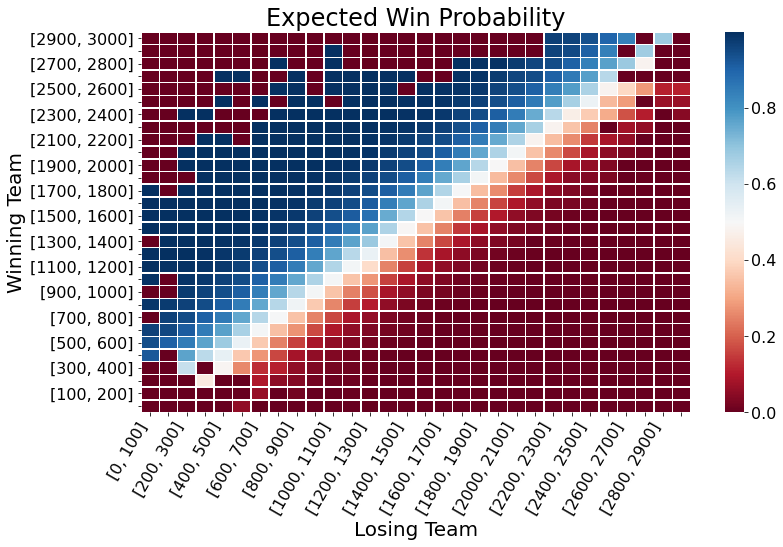

In [22]:
#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.xticks(ha='right')
plt.title("Expected Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

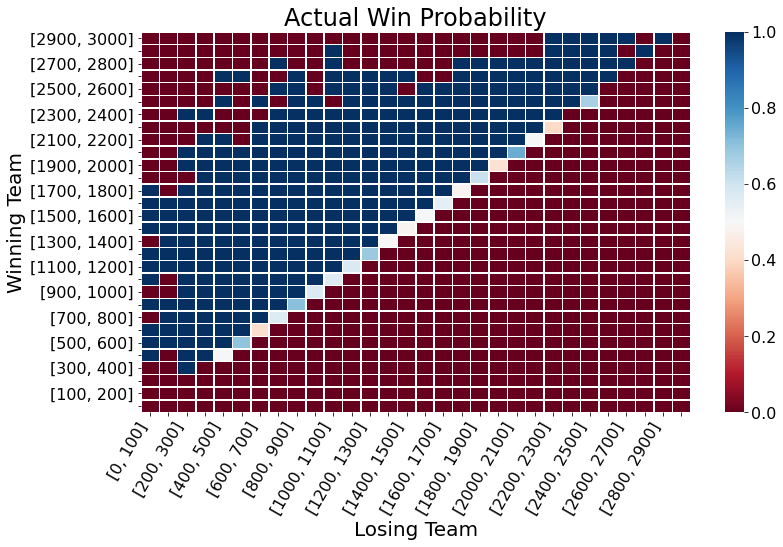

In [23]:
#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.xticks(ha='right')
plt.title("Actual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

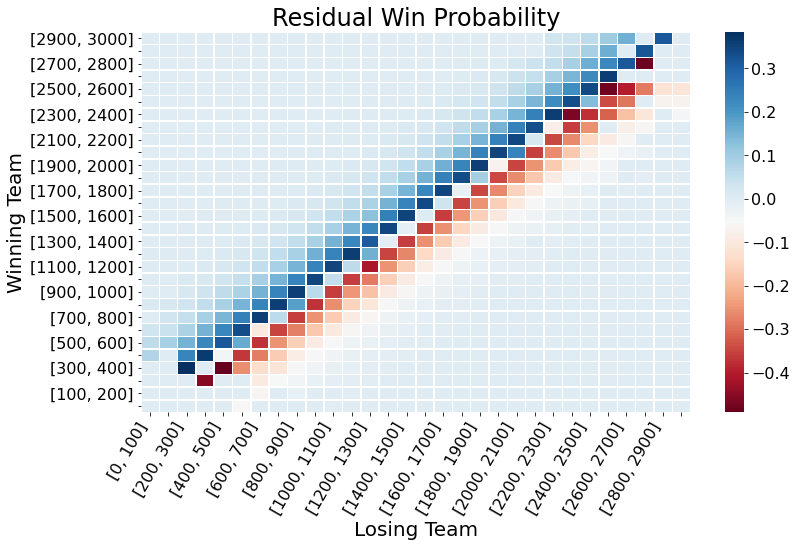

In [24]:

#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.xticks(ha='right')
plt.title("Residual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()